<a href="https://colab.research.google.com/github/djiraffs/Deep-Learning/blob/main/Week%207/Deep%20RNN/Deep_RNN_Deteksi_sarkasme_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [3]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import keras_tuner as kt
import requests

In [4]:
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)

# Pisahkan setiap baris, lalu decode masing-masing JSON
data = [json.loads(line) for line in response.text.split('\n') if line.strip()]

# Cek sampel
print("Jumlah data:", len(data))
print("Contoh data:", data[0])

sentences = [item['headline'] for item in data]
labels = [item['is_sarcastic'] for item in data]

vocab_size = 10000
oov_tok = ""
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', maxlen=100)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

Jumlah data: 26709
Contoh data: {'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}


## Training Model

In [6]:
def build_model(hp):
    model = tf.keras.Sequential()

    # Embedding layer
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int('embed_dim', 32, 128, step=32)
    ))

    # First RNN layer (return_sequences=True untuk menyambung ke RNN berikutnya)
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_1', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_1', [0.2, 0.3, 0.5]),
        return_sequences=True
    ))

    # Second RNN layer (return_sequences=True)
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_2', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_2', [0.2, 0.3, 0.5]),
        return_sequences=True
    ))

    # Third RNN layer (last one, return_sequences=False)
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_3', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_3', [0.2, 0.3, 0.5]),
        return_sequences=False
    ))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', [1e-3, 1e-4])),
        metrics=['accuracy']
    )

    return model


# Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='sarcasm_rnn_tuner',
    project_name='simple_rnn_tuning'
)

tuner.search(X_train, np.array(y_train), epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 01m 54s]
val_accuracy: 0.5584931969642639

Best val_accuracy So Far: 0.8451099395751953
Total elapsed time: 00h 09m 55s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Evaluasi

Epoch 1/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.9021 - loss: 0.2518 - val_accuracy: 0.8559 - val_loss: 0.3884
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9215 - loss: 0.2062 - val_accuracy: 0.8583 - val_loss: 0.4250
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9398 - loss: 0.1610 - val_accuracy: 0.8607 - val_loss: 0.4102
Epoch 4/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.9571 - loss: 0.1217 - val_accuracy: 0.8531 - val_loss: 0.4790
Epoch 5/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9652 - loss: 0.1004 - val_accuracy: 0.8534 - val_loss: 0.5218
Epoch 6/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9683 - loss: 0.0858 - val_accuracy: 0.8534 - val_loss: 0.5302
Epoch 7/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9722 - loss: 0.0772 - val_accuracy: 0.8529 - val_loss: 0.5982
Epoch 8/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9796 - loss: 0.0567 - 

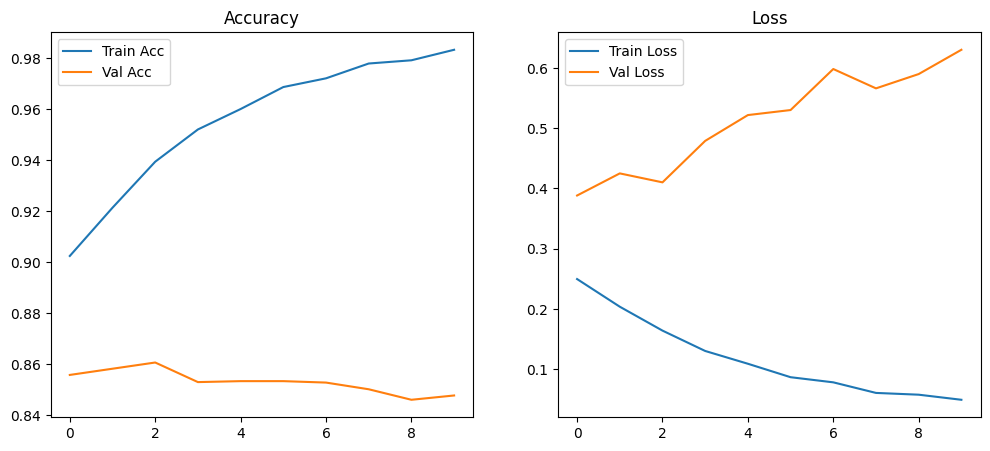

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Akurasi  : 0.8478
Presisi  : 0.8445
Recall   : 0.8009
F1-Score : 0.8221
AUC      : 0.9225


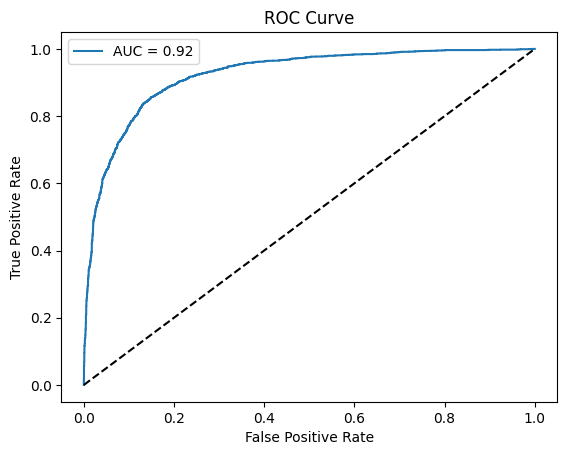

In [7]:
history = best_model.fit(X_train, np.array(y_train), epochs=10, validation_data=(X_test, np.array(y_test)))

# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()